<a href="https://colab.research.google.com/github/chiru-stefan/AE-Emb---AI-Proj/blob/stefan/Copy_of_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install your required packages here
!pip install pandas numpy matplotlib sklearn fsspec gcsfs

     |████████████████████████████████| 92kB 3.9MB/s 
     |████████████████████████████████| 1.3MB 7.7MB/s 
     |████████████████████████████████| 143kB 30.2MB/s 
     |████████████████████████████████| 296kB 31.2MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=392414b518bf98192ee992b7c7cfcfa45ba2b409f25d0e292024aaa51854f740
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [2]:
# Location of credentials for accessing buckets
%env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/My Drive/CS/AI/Credentials/ai-project-2020-f4dfbc25326c.json

env: GOOGLE_APPLICATION_CREDENTIALS=/content/drive/My Drive/CS/AI/Credentials/ai-project-2020-f4dfbc25326c.json


In [3]:
# Imports
from google.cloud import storage

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, LSTM, Activation, Input
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import Model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Define constants
bucket_name = "ai-project-2020-spotify"
client = storage.Client()
bucket = client.get_bucket(bucket_name)

In [6]:
# List bucket files
train_files = list(bucket.list_blobs(prefix='training_set/'))
for blob in [blob for blob in train_files if '20180715' in blob.name]:
  print(blob.name)

training_set/log_0_20180715_000000000000.csv.gz
training_set/log_1_20180715_000000000000.csv.gz
training_set/log_2_20180715_000000000000.csv.gz
training_set/log_3_20180715_000000000000.csv.gz
training_set/log_4_20180715_000000000000.csv.gz
training_set/log_5_20180715_000000000000.csv.gz
training_set/log_6_20180715_000000000000.csv.gz
training_set/log_7_20180715_000000000000.csv.gz


In [7]:
logs = pd.read_csv("/content/drive/My Drive/CS/AI/Data/training_set_mini.csv")
logs.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [8]:
unique_tracks = logs['track_id_clean'].nunique()
print(unique_tracks)

50704


In [9]:
def categorical_to_dummies(df, categorical_cols):
    """ Create dummies (one hot encoding) for each categorical variables """
    dummies = pd.get_dummies(df[categorical_cols], prefix=categorical_cols)
    return df.drop(columns=categorical_cols).join(dummies)

In [10]:
# remove date for convenience (could encode this as well)
logs.drop(columns=['date'], inplace=True)

# Create dummies (one hot encoding) for each categorical variable in logs
categorical_cols = ['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end']
logs = categorical_to_dummies(logs, categorical_cols)

In [11]:
track_features = pd.read_csv('/content/drive/My Drive/CS/AI/Data/track_features_mini.csv').set_index('track_id')
track_features = categorical_to_dummies(track_features, ['mode'])

In [12]:
data = logs.join(track_features, on='track_id_clean', how='left').drop(columns=['track_id_clean'])

In [13]:
c_data = data[['session_id', 'session_position', 'duration', 'release_year',
       'us_popularity_estimate', 'acousticness', 'beat_strength', 'bounciness',
       'danceability', 'dyn_range_mean', 'energy', 'flatness',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mechanism', # 'mode',
       'organism', 'speechiness', 'tempo', 'time_signature', 'valence',
       'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
       'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
       'acoustic_vector_6', 'acoustic_vector_7']]

In [14]:
train_session_part = [_ for _ in range(15)]
test_session_part = [_ for _ in range(15, 21)]

x_train = c_data.loc[c_data.session_position.isin(train_session_part)].set_index('session_id')
x_test = c_data.loc[c_data.session_position.isin(test_session_part)].set_index('session_id')
y_train = data.loc[data.session_position.isin(train_session_part)].skip_2
# y_train = np.reshape(y_train, (y_train.shape[0], x_train.shape[1]))
y_test = data.loc[data.session_position.isin(test_session_part)].skip_2
# y_test = np.reshape(y_test, (y_test.shape[0], x_test.shape[1]))

In [15]:
model = Sequential()
model.add(Input(shape=(None, 29)))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=True))

# model.add(Dropout(0.5))
model.add(Dense(1, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

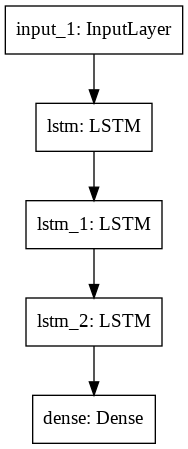

In [16]:
from keras.utils import plot_model
plot_model(model)

In [17]:
data_path = '/content/drive/My Drive/CS/AI/saved_models'
checkpointer = ModelCheckpoint(filepath=data_path + '/LSTM_model-{epoch:02d}.hdf5', verbose=1)

In [18]:
x_train = np.expand_dims(x_train, axis=0)
y_train = np.expand_dims(y_train, axis=0)

In [19]:
model.fit(x_train, y_train, batch_size=1000, epochs=3, callbacks=[checkpointer])

Epoch 1/3
1/1 [==============================] - ETA: 0s - loss: 803000.8125 - accuracy: 0.4871
Epoch 00001: saving model to /content/drive/My Drive/CS/AI/saved_models/LSTM_model-01.hdf5
1/1 [==============================] - 0s 4ms/step - loss: 803000.8125 - accuracy: 0.4871
Epoch 2/3
1/1 [==============================] - ETA: 0s - loss: 802334.6875 - accuracy: 0.4871
Epoch 00002: saving model to /content/drive/My Drive/CS/AI/saved_models/LSTM_model-02.hdf5
1/1 [==============================] - 0s 4ms/step - loss: 802334.6875 - accuracy: 0.4871
Epoch 3/3
1/1 [==============================] - ETA: 0s - loss: 802320.3750 - accuracy: 0.5129
Epoch 00003: saving model to /content/drive/My Drive/CS/AI/saved_models/LSTM_model-03.hdf5
1/1 [==============================] - 0s 4ms/step - loss: 802320.3750 - accuracy: 0.5129


### ***From here on is Jens code***
########################################

In [20]:
def stack_sessions(df):
    """
    Turn matrix representation into vector by stacking the listen events together (as columns)
    For example:
    session_id session_position feature1 feature2
    a          1                ~        ~
    a          2                ~        ~
    b          1                ~        ~
    b          2                ~        ~
    b          3                ~        ~

    Turns into:
    session_id 1_feature1 1_feature2 2_feature1 2_feature2 3_feature1 3_feature2
    a          ~          ~          ~          ~          Nan        Nan
    b          ~          ~          ~          ~          ~          ~
    """
    columns = list(df.columns)
    columns.remove('session_id')
    columns.remove('session_position')
    sessions = df.pivot(index='session_id', columns='session_position', values=columns)
    return sessions

In [21]:
# Stack all Sessions
model_input = stack_sessions(data)
model_input_original = model_input.copy(deep=True)
# Drop all features except track_id, skip_2, session_ids
model_input.head()

session_length          ... mode_minor          
session_position                                   1   2   3   ...         18   19   20
session_id                                                     ...                     
0_00006f66-33e5-4de7-a324-2d18e439fc1e             20  20  20  ...          1    1    0
0_0000a72b-09ac-412f-b452-9b9e79bded8f             20  20  20  ...          0    1    0
0_00010fc5-b79e-4cdf-bc4c-f140d0f99a3a             20  20  20  ...          0    1    1
0_00016a3d-9076-4f67-918f-f29e3ce160dc             20  20  20  ...          0    0    0
0_00018b58-deb8-4f98-ac5e-d7e01b346130             11  11  11  ...        NaN  NaN  NaN

[5 rows x 1320 columns]

In [ ]:
# Add noise to the skip_2 values
for i, row in model_input.iterrows():
  for index in range(1, 20):
    value = row[('skip_2', index)]
    if not math.isnan(value):
      noise = np.random.randint(2, size=1)
      noisy_value = np.bitwise_and(int(value), noise[0])
      model_input.at[i,('skip_2', index)] = noisy_value

In [ ]:
model_input.head()

In [ ]:
model_input.reset_index(inplace=True)
model_input.drop(columns=['session_id'])
model_input_original.reset_index(inplace=True)
model_input_original.drop(columns=['session_id'])

In [ ]:
%%time
from sklearn.impute import SimpleImputer

# Fill in NaN values with mean of column. This choice *should* depend on your decision of classifier and feature encoding. Not every approach has the same assumptions about the data.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
train_data_imp = imp.fit_transform(model_input.drop(columns=['session_id']))
val_data_imp = imp.transform(model_input_original.drop(columns=['session_id']))